<img src = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.deepai.org%2Fconverted-papers%2F2001.04758%2Fx7.png&f=1&nofb=1&ipt=4267ee8c2ec710ca49a6ecc695bffcb07c6031f771cf313186a358e3cd3977b4&ipo=images' class="center">

# **Import necessary library**

In [1]:
!pip install -q noisereduce
!pip wheel -q https://github.com/Borda/kaggle_image-classify/archive/refs/heads/main.zip --wheel-dir frozen_packages
!pip wheel -q https://github.com/PyTorchLightning/lightning-flash/archive/refs/heads/feature/soft_targets.zip --wheel-dir frozen_packages
!rm frozen_packages/torch*
!ls -l frozen_packages | grep -e kaggle -e flash

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.1.0 requires SoundFile<0.12.0,>=0.10.0, but you have soundfile 0.12.1 which is incompatible.
  ERROR: HTTP error 404 while getting https://github.com/PyTorchLightning/lightning-flash/archive/refs/heads/feature/soft_targets.zip
ERROR: Could not install requirement https://github.com/PyTorchLightning/lightning-flash/archive/refs/heads/feature/soft_targets.zip because of HTTP error 404 Client Error: Not Found for url: https://codeload.github.com/Lightning-Universe/lightning-flash/zip/refs/heads/feature/soft_targets for URL https://github.com/PyTorchLightning/lightning-flash/archive/refs/heads/feature/soft_targets.zip
-rw-r--r-- 1 root root     21859 Nov  5 04:31 kaggle_image_classification-2022.5-py3-none-any.whl


In [2]:
import os
import pandas as pd

import torchaudio
from tqdm.auto import tqdm
from joblib import Parallel,delayed
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm
from functools import partial
from joblib import Parallel, delayed
import glob
from pprint import pprint



import torch
import torchaudio
import noisereduce
import matplotlib.pyplot as plt
import numpy as np
import librosa
from math import ceil
from pprint import pprint
from torch import Tensor
from torch.utils.data import DataLoader


# **Load the data**

In [3]:
Path = "/kaggle/input/birdclef-2023"
path_csv = os.path.join(Path, "train_metadata.csv")
train_meta = pd.read_csv(path_csv).sample(frac=1)
display(train_meta.head())

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
1796,blacuc1,[],['song'],5.3282,-1.3893,Cuculus clamosus,Black Cuckoo,James Lidster,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/360421,blacuc1/XC360421.ogg
1007,barswa,[],['song'],28.3686,-108.9283,Hirundo rustica,Barn Swallow,Richard E. Webster,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/337983,barswa/XC337983.ogg
3256,categr,[],['call'],13.9909,-87.1798,Bubulcus ibis,Cattle Egret,Alfonso Auerbach,Creative Commons Attribution-NonCommercial-Sha...,0.5,https://www.xeno-canto.org/298914,categr/XC298914.ogg
6373,egygoo,[],"['call', 'flight call']",51.1403,4.9931,Alopochen aegyptiaca,Egyptian Goose,Niels Van Doninck,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/553832,egygoo/XC553832.ogg
12894,somtit4,[],"['adult', 'call', 'sex uncertain', 'song']",-2.8140,37.5034,Melaniparus thruppi,Somali Tit,isaac kilusu,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/647024,somtit4/XC647024.ogg


# **Let check length of particular recording**

In [4]:
#explore audio data lengths

def get_length(fn):
    fp = os.path.join(Path,"train_audio",fn)
    waveform,sample_rate = torchaudio.load(fp)
    return waveform.size()[-1]

sizes = Parallel(n_jobs = os.cpu_count())(delayed(get_length)(fn) for fn in tqdm(train_meta["filename"]))

  0%|          | 0/16941 [00:00<?, ?it/s]

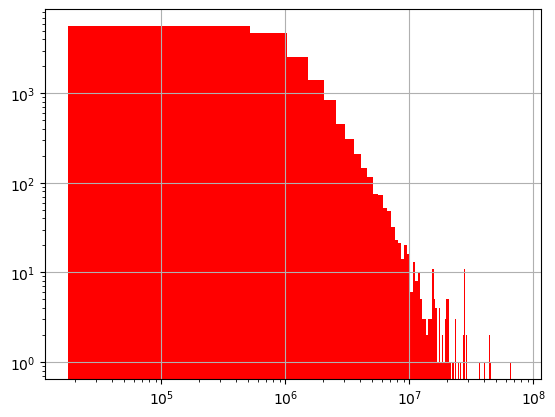

In [5]:
plt.hist(sizes, bins=150,color='red')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid()

# **Convert audio to set of spectrogram**

In [6]:
SPECTROGRAM_PARAMS = dict(
    sample_rate=32_000,
    hop_length=640,
    n_fft=800,
    n_mels=128,
    fmin=20,
    fmax=16_000,
    win_length=512
)
PCEN_PARAS = dict(
    time_constant=0.06,
    eps=1e-6,
    gain=0.8,
    power=0.25,
    bias=10,
)


@torch.no_grad()
def create_spectrogram(
    fname: str,
    reduce_noise: bool = False,
    frame_size: int = 5,
    frame_step: int = 2,
    spec_params: dict = SPECTROGRAM_PARAMS,
) -> list:
    waveform, sample_rate = librosa.core.load(fname, sr=spec_params["sample_rate"], mono=True)
    if reduce_noise:
        waveform = noisereduce.reduce_noise(
            y=waveform,
            sr=sample_rate,
            time_constant_s=float(frame_size),
            time_mask_smooth_ms=250,
            n_fft=spec_params["n_fft"],
            use_tqdm=False,
            n_jobs=2,
        )

    step = int(frame_step * sample_rate)
    size = int(frame_size * sample_rate)
    count = ceil((len(waveform) - size) / float(step))
    frames = []
    for i in range(max(1, count)):
        begin = i * step
        frame = waveform[begin:begin + size]
        if len(frame) < size:
            if i == 0:
                rep = round(float(size) / len(frame))
                frame = frame.repeat(int(rep))
            elif len(frame) < (size * 0.33):
                continue
            else:
                frame = waveform[-size:]
        frames.append(frame)

    spectrograms = []
    for frm in frames:
        sg = librosa.feature.melspectrogram(
            y=frm,
            sr=sample_rate,
            n_fft=spec_params["n_fft"],
            win_length=spec_params["win_length"],
            hop_length=spec_params["hop_length"],
            n_mels=spec_params["n_mels"],
            fmin=spec_params["fmin"],
            fmax=spec_params["fmax"],
            power=1,
        )
#         sg = librosa.pcen(sg, sr=sample_rate, hop_length=spec_params["hop_length"], **PCEN_PARAS)
        sg = librosa.amplitude_to_db(sg, ref=np.max)
        spectrograms.append(np.nan_to_num(sg))
    return spectrograms

/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg
-80.0 -2.30968e-07
-80.0 -2.30968e-07
-78.95756 0.0
-78.22531 0.0
-80.0 1.1920929e-07
-80.0 1.1920929e-07
-80.0 1.1920929e-07
-76.69825 -1.9073486e-06
-80.0 -1.1920929e-07
-80.0 -1.1920929e-07
-80.0 -1.1920929e-07
-78.775566 0.0
-80.0 0.0
-80.0 0.0
-80.0 0.0
-79.16542 0.0
-80.0 2.3841858e-07
-80.0 2.3841858e-07
-80.0 2.3841858e-07
-80.0 0.0
-80.0 1.1920929e-07


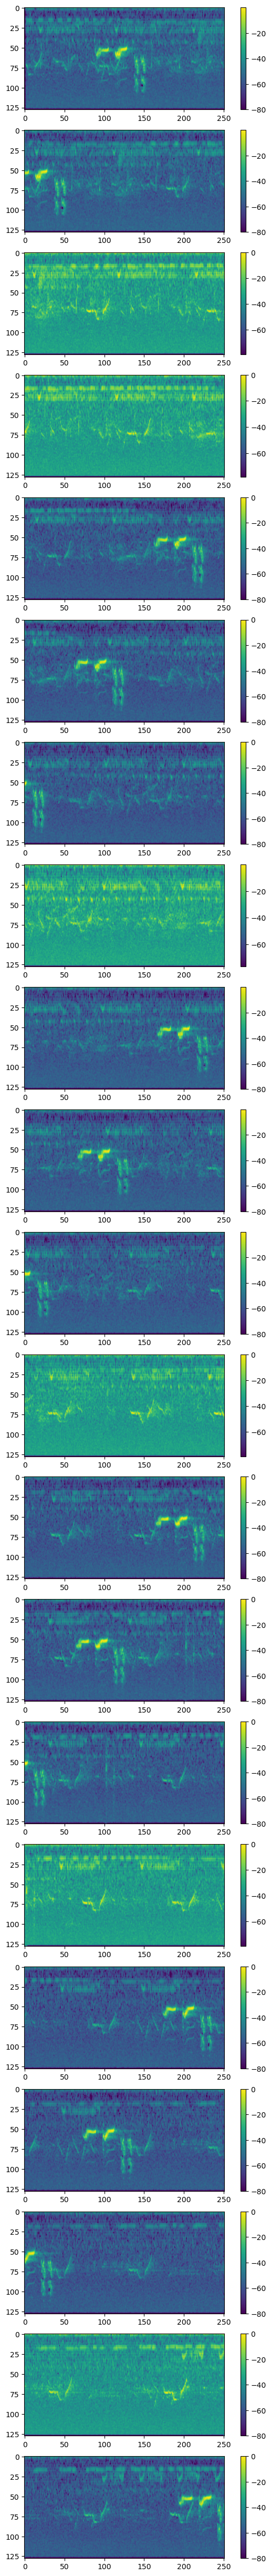

In [7]:
path_audio = os.path.join(Path, "train_audio", "abethr1/XC128013.ogg")
# path_audio = os.path.join(PATH_DATASET, "train_audio", "elepai/XC27344.ogg")
# path_audio = os.path.join(PATH_DATASET, "train_audio", "hawgoo/XC210217.ogg")
print(path_audio)
sgs = create_spectrogram(path_audio, reduce_noise=False)


fig, axarr = plt.subplots(nrows=len(sgs), figsize=(8, 3 * len(sgs)))
for i, sg in enumerate(sgs):
    print(np.min(sg), np.max(sg))
    im = axarr[i].imshow(sg)  # librosa
    plt.colorbar(im, ax=axarr[i])


# **Export only frames form the recording beginning and ending**

In [8]:
def convert_and_export(
    fn: str, path_in: str, path_out: str,
    reduce_noise: bool = False,
    frame_size: int = 5, frame_step: int = 2,
    img_extension=".png",
) -> None:
    path_audio = os.path.join(path_in, fn)
    try:
        sgs = create_spectrogram(
            path_audio,
            reduce_noise=reduce_noise,
            frame_size=frame_size,
            frame_step=frame_step,
        )
    except Exception as ex:
        print(f"Failed conversion for audio: {path_audio}")
        return
    if not sgs:
        print(f"Too short audio for: {path_audio}")
        return
    # see: https://www.kaggle.com/c/birdclef-2022/discussion/308861
    # this is adjustment for window 5s and step 2s
    nb = ceil((10 - frame_size) / frame_step) + 1
    if len(sgs) > 2 * nb:
        sgs = sgs[:nb] + sgs[-nb:]
    path_npz = os.path.join(path_out, fn + '.npz')
    os.makedirs(os.path.dirname(path_npz), exist_ok=True)
    # np.savez_compressed(path_npz, np.array(sgs, dtype=np.float16))
    for i, sg in enumerate(sgs):
        path_img = os.path.join(path_out, fn + f".{i:03}" + img_extension)
        try:
            # plt.imsave(path_img, sg, vmin=-70, vmax=20)
            sg = (sg + 80) / 80.0
            sg = np.clip(sg, a_min=0, a_max=1) * 255
            img = Image.fromarray(sg.astype(np.uint8))
            img.resize((256,256)).save(path_img)
        except Exception as ex:
            print(f"Failed exporting for image: {path_img}")
            continue



# **Conversion of full dataset**

In [9]:
_convert_and_export = partial(
    convert_and_export,
    path_in=os.path.join(Path, "train_audio"),
    path_out="train_images",
)

_= Parallel(n_jobs=3)(delayed(_convert_and_export)(fn) for fn in tqdm(train_meta["filename"]))
# _= list(map(_convert_and_export, tqdm(train_meta["filename"])))



  0%|          | 0/16941 [00:00<?, ?it/s]

abethr1/XC363501.ogg
['train_images/abethr1/XC363501.ogg.000.png',
 'train_images/abethr1/XC363501.ogg.001.png',
 'train_images/abethr1/XC363501.ogg.002.png',
 'train_images/abethr1/XC363501.ogg.003.png',
 'train_images/abethr1/XC363501.ogg.004.png',
 'train_images/abethr1/XC363501.ogg.005.png',
 'train_images/abethr1/XC363501.ogg.006.png']
train_images/abethr1/XC363501.ogg.001.png
(256, 256)


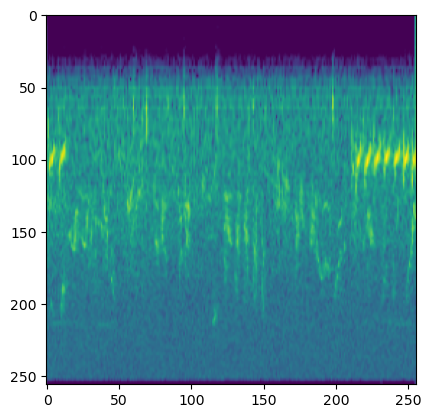

In [10]:
print(train_meta["filename"][1])
imgs = glob.glob(os.path.join("train_images", train_meta["filename"][1] + ".*.png"))
pprint(sorted(imgs))

path_img = imgs[0]
print(path_img)
img = plt.imread(path_img)
print(img.shape)
plt.imshow(img)



# **Color normalization**

In [11]:
def _color_means(img_path):
    img = plt.imread(img_path)
    if np.max(img) > 1.5:
        img = img / 255.0
    clr_mean = np.mean(img) if img.ndim == 2 else {i: np.mean(img[..., i]) for i in range(3)}
    clr_std = np.std(img) if img.ndim == 2 else {i: np.std(img[..., i]) for i in range(3)}
    return clr_mean, clr_std

images = glob.glob(os.path.join("train_images", "*", "*.png"))
clr_mean_std = Parallel(n_jobs=os.cpu_count())(delayed(_color_means)(fn) for fn in tqdm(images))

  0%|          | 0/105535 [00:00<?, ?it/s]

In [12]:
img_color_mean = pd.DataFrame([c[0] for c in clr_mean_std]).describe()
display(img_color_mean.T)

,count,mean,std,min,25%,50%,75%,max
0,105535.0,0.389251,0.129949,0.005936,0.298569,0.392578,0.481644,0.929736


In [13]:
img_color_std = pd.DataFrame([c[1] for c in clr_mean_std]).describe()
display(img_color_std.T)

,count,mean,std,min,25%,50%,75%,max
0,105535.0,0.155383,0.039158,0.002104,0.128152,0.149941,0.176816,0.369677


In [14]:
img_color_mean = list(img_color_mean.T["mean"])
img_color_std = list(img_color_std.T["mean"])
print(img_color_mean, img_color_std)

[0.38925081491470337] [0.15538324415683746]
